# Introduction
We take the 2-layer MLP from previous video and make it deeper with a tree-like structure, arriving at a convolutional neural network architecture similar to the [WaveNet](https://arxiv.org/abs/1609.03499) (2016) from DeepMind.

# Libraries

In [1]:
%matplotlib inline
%config IPCompleter.use_jedi=False

In [2]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Data

### Reading the Data

In [3]:
# Reading names into a list
with open('../../data/names.txt', 'r') as f:
    names = f.readlines()
    names = [name.strip() for name in names]

### Creating Vocabulary

In [4]:
# Building the vocabulary (character to/from index)
chars = sorted(list(set(''.join(names))))
chr_to_idx = {s:i+1 for i,s in enumerate(chars)}; print(chr_to_idx)
chr_to_idx['.'] = 0
idx_to_chr = {i:s for s,i in chr_to_idx.items()}; print(idx_to_chr)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Building dataset
This time we use a longer block size of eight!

In [5]:
def build_dataset(words: list, block_size: int = 3, verbose: bool = False) -> tuple:
    """
    Description:
        Take a list of words and creates Xs and Ys give
        a block size. E.g. block_size=3 for emma would 
        result in:
            ... ---> e  
            ..e ---> m  
            .em ---> m  
            emm ---> a  
            mma ---> . 
        Stored in a (n, 3) tensor
    Inputs:
        words: List of words
        block_size: The context window
        verbose: Where to print the outputs
    Ouputs:
        A (n, block_size) tensor with Xs
        A (n) tensor with Ys
    """
    X, Y = [], []
    for word in words:
        if verbose:
            print(word)
        context = [0] * block_size
        for char in word + '.':
            idx = chr_to_idx[char]
            X.append(context)
            Y.append(idx)
            if verbose:
                print(''.join(idx_to_chr[i] for i in context), idx_to_chr[idx])
            context = context[1:] + [idx]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X, Y

In [6]:
# Putting names in random order
random.shuffle(names)

# Creating split indices
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

In [7]:
# Building training, validation and test sets
Xtr, Ytr = build_dataset(words=names[:n1], block_size=8); print(Ytr.size())
Xval, Yval = build_dataset(words=names[n1:n2], block_size=8); print(Yval.size())
Xtest, Ytest = build_dataset(words=names[n2:], block_size=8); print(Ytest.size())

torch.Size([182498])
torch.Size([22789])
torch.Size([22859])


In [8]:
# Example of x and y
for x,y in zip(Xtr[:20],Ytr[:20]):
    print(''.join(idx_to_chr[ix.item()] for ix in x), '-->', idx_to_chr[y.item()])

........ --> c
.......c --> y
......cy --> r
.....cyr --> u
....cyru --> s
...cyrus --> .
........ --> k
.......k --> h
......kh --> y
.....khy --> r
....khyr --> i
...khyri --> e
..khyrie --> .
........ --> p
.......p --> r
......pr --> a
.....pra --> n
....pran --> i
...prani --> s
..pranis --> h


# Network Building Blocks
We we just reuse the blocks we created in a previous notebook.

In [9]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        """ Initializes Weights """
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        """ Forward Pass """
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        """ Returning  All Parameters """
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [10]:
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        """ Initializing Batchnorm Weights """
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # Batchnorm Shift Parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # Running batchnorm Mean and Variance
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        """ Forward Pass and Buffers """
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [11]:
class Tanh:
    def __call__(self, x):
        """ Non-linearity """
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [12]:
class Embedding:
  
    def __init__(self, num_embeddings, embedding_dim):
        """ Initializing Embedding Weights """
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        """ Forward Pass """
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        """ Returning All Parameters """
        return [self.weight]

In [13]:
class Flatten:
  
    def __call__(self, x):
        """ Flattens Final Dimension """
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        """ Returning All Parameters """
        return []

In [14]:
class Sequential:
  
    def __init__(self, layers):
        """ Saves a Reference to the Layers """
        self.layers = layers

    def __call__(self, x):
        """ Calls Layers Iteratively """
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
  
    def parameters(self):
        """ Returns All Parameters """
        return [p for layer in self.layers for p in layer.parameters()]

# Training a Network
Here we build a simple network and train it. It will be this network that we continously expand in the next notebook.

In [15]:
# Initializing Weights
n_embd = 10
n_hidden = 200
block_size = 8
vocab_size = len(chr_to_idx)

# Model
model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# Adjusing initialization of layers
with torch.no_grad():
    # Making last layer less confident
    model.layers[-1].weight *= 0.1

# All parameters
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


In [16]:
max_steps = 200000
batch_size = 64
lr = 0.2
lossi = []

for step in range(max_steps):
    
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)    
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    lr = lr if step < 150000 else 0.01
    for p in parameters:
        p.data += -lr * 0.01 * p.grad        
        
    # Tracking stats
    if not step % 10000:
        print(f"{step:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.2975
  10000/ 200000: 2.5396
  20000/ 200000: 2.7344
  30000/ 200000: 2.4083
  40000/ 200000: 2.2558
  50000/ 200000: 2.2601
  60000/ 200000: 2.3485
  70000/ 200000: 2.4415
  80000/ 200000: 2.3535
  90000/ 200000: 2.2707
 100000/ 200000: 2.1816
 110000/ 200000: 2.1921
 120000/ 200000: 2.0696
 130000/ 200000: 2.2801
 140000/ 200000: 2.0228
 150000/ 200000: 2.0431
 160000/ 200000: 2.4591
 170000/ 200000: 1.8949
 180000/ 200000: 2.0612
 190000/ 200000: 2.3091


In [89]:
# Printing layer shapes
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (64, 8, 10)
FlattenConsecutive : (64, 80)
Linear : (64, 200)
BatchNorm1d : (64, 200)
Tanh : (64, 200)
Linear : (64, 27)


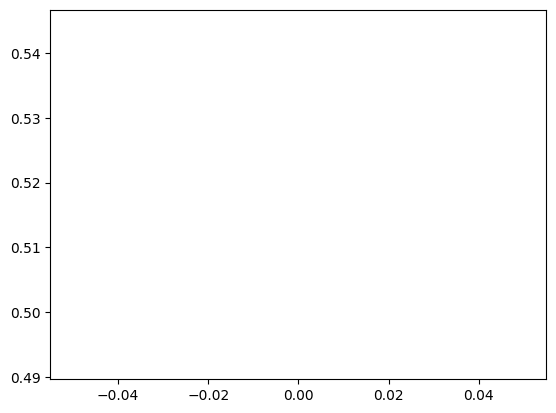

In [94]:
# Plotting loss
plt.plot(lossi)

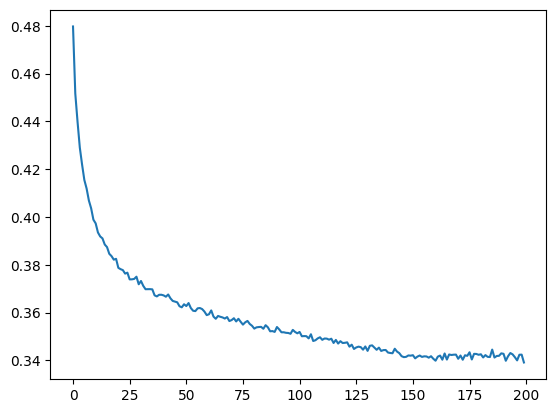

In [18]:
# Plotting a prettier loss
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [95]:
# Putting layers into eval mode
for layer in model.layers:
    layer.training = False

In [96]:
# Evaluating the loss
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'valid': (Xval, Yval),
        'test': (Xtest, Ytest),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('valid')

train 3.3022239208221436
valid 3.3020124435424805


In [97]:
# Sampling from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        # Forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        
        # Sampling the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        
        # Shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        
        # If we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(idx_to_chr[i] for i in out))

eghdzgwqjiiukrxqrpgfbfoozdwihkeyfko.
dtrhhst.
kzs.
fiziztwcsdjrznlwgmkfcdx.
vcckkanfnzdjtqiuatknucsmalpsqhnayqcsexwzwuedrnpzzarnekemgbeeaykw.
iulodwgyuqghedcmiuerpwwubsnbztgmigeagtlyafdorjnvcoytliwawkpikmuubgmd.
svgsgpmqxtosisopttnmhobsr.
mxukzriomykh.
gklvaglqghmyzj.
qeuuspkekuduit.
kurhlfxkrefkkmyfzrrtnmprzbrj.
bslioglvjhmzovavcrmfknrixpycnizfwsrbvhygnnyxp.
sjroqwmwbbwuycj.
t.
xcinzjdnunzgqeml.
ebthasgdbwnzclzikfvzvhphbeltwcoljdvccbaukfm.
wxcjhppvoeysyqoxlhmkjrcnmwqxzwuqvtsgukulvgh.
fln.
skw.
txbpjuggxzacvoqspudsfrataqvityatmcdoeazwdmwtvvzkptmequllvqjxn.


# The WaveNet Architecture: Part I
He we will slowly change the current architecture into the WaveNet architecture.

In [22]:
# Batch with four examples
idx = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[idx], Ytr[idx]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  3,  9, 14, 17],
        [ 0,  0,  0,  0,  0,  3,  1, 12]])

In [24]:
# Output of Embedding layer
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [26]:
# Output of Flatten layer
model.layers[1].out.shape

torch.Size([4, 80])

In [25]:
# Output of Linear layer
model.layers[2].out.shape

torch.Size([4, 200])

When doing matrix multiplications it is only the last dimension that matters, while the other dimensions are maintained. This also means that one e.g. can maintain a "batch dimension" throughout ones calculations.

In [28]:
# Showing that only last dimension matters
(torch.randn(4,5,6,80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 6, 200])

For the WaveNet architecture, we want each linear layer to fuse two characters as illustrated in the example below. In this example imagine having to samples, four characters, length three embeddings. 

In [71]:
# Embedding example (samples, characters, embedding)
x = torch.tensor(list(range(24))).view(2,4,3);x

tensor([[[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8],
         [ 9, 10, 11]],

        [[12, 13, 14],
         [15, 16, 17],
         [18, 19, 20],
         [21, 22, 23]]])

In [72]:
# Flattening char1 + char2 and char3 + char4
n = 2 # Size of character groups
B, T, C = x.shape
x = x.view(B, T//n, C*n);x

tensor([[[ 0,  1,  2,  3,  4,  5],
         [ 6,  7,  8,  9, 10, 11]],

        [[12, 13, 14, 15, 16, 17],
         [18, 19, 20, 21, 22, 23]]])

Now let us implement this into the flatten layer, such that its eight characters can divided into four groups of two characters (each represented by a length 10 embedding).

In [73]:
class FlattenConsecutive:
    
    def __init__(self, n):
        """ Size of Groups of Characters """
        self.n = n
  
    def __call__(self, x):
        """ Flattens Groups of Characters """
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        """ Returning All Parameters """
        return []

In [81]:
# Checking if we produce same results
x = torch.tensor(list(range(24))).view(2,4,3);x
FlattenConsecutive(2)(x)

tensor([[[ 0,  1,  2,  3,  4,  5],
         [ 6,  7,  8,  9, 10, 11]],

        [[12, 13, 14, 15, 16, 17],
         [18, 19, 20, 21, 22, 23]]])

# Training WaveNet: Part I
Here we try out our changes to the flatten layer, while also restructuring the consecutive layers such that they fit the new dimensions. The training loop remains the same.

In [98]:
# Initializing Weights
n_embd = 10
n_hidden = 68 # To maintain same number of parameters as before
block_size = 8
vocab_size = len(chr_to_idx)

# Model
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# Adjusing initialization of layers
with torch.no_grad():
    # Making last layer less confident
    model.layers[-1].weight *= 0.1

# All parameters
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

170897


In [99]:
max_steps = 200000
batch_size = 64
lr = 0.2
lossi = []

for step in range(max_steps):
    
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)    
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    lr = lr if step < 150000 else 0.01
    for p in parameters:
        p.data += -lr * 0.01 * p.grad        
        
    # Tracking stats
    if not step % 10000:
        print(f"{step:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3046
  10000/ 200000: 2.4840
  20000/ 200000: 2.2932
  30000/ 200000: 2.2576
  40000/ 200000: 2.2168
  50000/ 200000: 1.9239
  60000/ 200000: 2.2394
  70000/ 200000: 2.0329
  80000/ 200000: 1.8825
  90000/ 200000: 2.3298
 100000/ 200000: 2.2283
 110000/ 200000: 1.9634
 120000/ 200000: 2.0114
 130000/ 200000: 1.9212
 140000/ 200000: 2.0269
 150000/ 200000: 1.9801
 160000/ 200000: 2.1339
 170000/ 200000: 1.8648
 180000/ 200000: 2.2444
 190000/ 200000: 2.0944


In [100]:
# Printing layer shapes
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (64, 8, 10)
FlattenConsecutive : (64, 4, 20)
Linear : (64, 4, 200)
BatchNorm1d : (64, 4, 200)
Tanh : (64, 4, 200)
FlattenConsecutive : (64, 2, 400)
Linear : (64, 2, 200)
BatchNorm1d : (64, 2, 200)
Tanh : (64, 2, 200)
FlattenConsecutive : (64, 400)
Linear : (64, 200)
BatchNorm1d : (64, 200)
Tanh : (64, 200)
Linear : (64, 27)


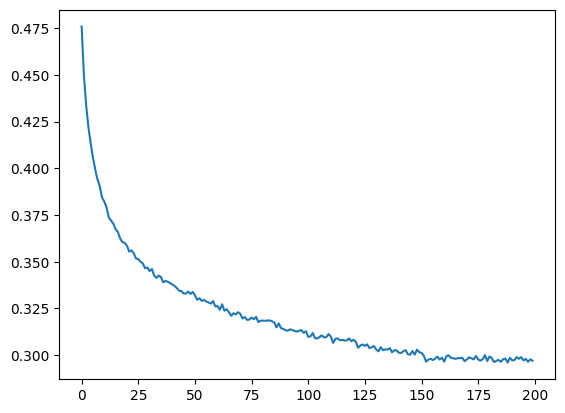

In [101]:
# Plotting loss
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [103]:
# Putting layers into eval mode
for layer in model.layers:
    layer.training = False

In [104]:
# Evaluating the loss
split_loss('train')
split_loss('valid')

train 1.9611910581588745
valid 2.038606882095337


# The WaveNet Architecture: Part II
Our batch norm layer was originally built to handle two-dimensional tensors, but as we added a dimension to accomodate the new architecture the old bachnorm layer now introduces a bug. Here we rewrite the BacchNorm-class such that it handles more dimensions but taking just a single mean over the extra dimensions instead of making multiple means.

In [106]:
class BatchNorm2d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        """ Initializing Batchnorm Weights """
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # Batchnorm Shift Parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # Running batchnorm Mean and Variance
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        """ Forward Pass and Buffers """
        if self.training:
            if x.ndim == 2:
                dim = 0
            if x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

# Training WaveNet: Part II
Here we try out our changes to the batchnorm layer.

In [115]:
# Initializing Weights
n_embd = 24
n_hidden = 128
block_size = 8
vocab_size = len(chr_to_idx)

# Model
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm2d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm2d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm2d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# Adjusing initialization of layers
with torch.no_grad():
    # Making last layer less confident
    model.layers[-1].weight *= 0.1

# All parameters
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [116]:
max_steps = 200000
batch_size = 32
lr = 0.1
lossi = []

for step in range(max_steps):
    
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)    
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    lr = lr if step < 150000 else 0.01
    for p in parameters:
        p.data += -lr * 0.01 * p.grad        
        
    # Tracking stats
    if not step % 10000:
        print(f"{step:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3123
  10000/ 200000: 2.7683
  20000/ 200000: 2.5023
  30000/ 200000: 2.2684
  40000/ 200000: 2.4498
  50000/ 200000: 2.1787
  60000/ 200000: 2.3923
  70000/ 200000: 1.8948
  80000/ 200000: 2.2357
  90000/ 200000: 2.1548
 100000/ 200000: 2.3416
 110000/ 200000: 2.3453
 120000/ 200000: 2.1047
 130000/ 200000: 2.0341
 140000/ 200000: 2.3591
 150000/ 200000: 1.6917
 160000/ 200000: 2.2811
 170000/ 200000: 2.2195
 180000/ 200000: 2.0671
 190000/ 200000: 1.8387


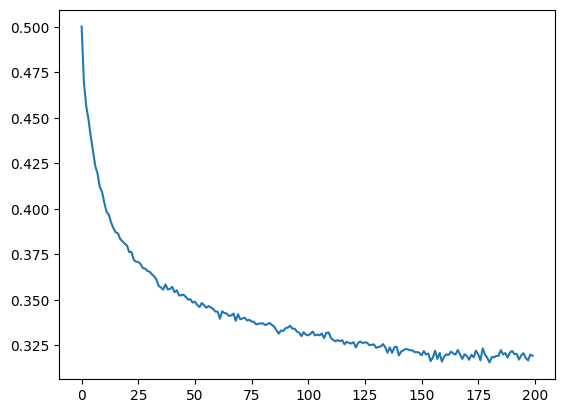

In [117]:
# Plotting loss
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [118]:
# Putting layers into eval mode
for layer in model.layers:
    layer.training = False

In [119]:
# Evaluating the loss
split_loss('train')
split_loss('valid')

train 2.073917865753174
valid 2.106062889099121


# Final Notes
Though it seems like the models are becoming better, we will need a bigger setup to verify this. E.g. we during training we should evaluate the model on the validation set to see when to stop, and when we have out final models we should test them on the "test" dataset for comparison. Also we have no experiment tracking. Many of these things will be covered in the following lessons. 